### Document Clustering
EXISTING script.

Since downloading a wikipedia dump, I've started my code over from scratch. `reformat.py` contains some important code to preprocess the outputted wiki dump from the wikiextractor I used.

This notebook will open a few sample JSON files and attempt to cluster them and label the clusters. This isn't hierarchical right now (only 1 level of clustering).

The

In [3]:
import json
import glob

In [4]:
CLUSTER_SIZE = 50

In [5]:
wiki_articles = []
for x in glob.glob('data/wiki*.json'):
    new_articles = json.load(open(x))['articles']
    wiki_articles += new_articles
wiki_articles[0].keys()

dict_keys(['url', 'title', 'text', 'id'])

In [6]:
for article in wiki_articles[:5]:
    for key, val in article.items():
        if key != 'text':
            print(key, ':', val)

url : https://en.wikipedia.org/wiki?curid=894
title : Agnosticism
id : 894
url : https://en.wikipedia.org/wiki?curid=896
title : Argon
id : 896
url : https://en.wikipedia.org/wiki?curid=897
title : Arsenic
id : 897
url : https://en.wikipedia.org/wiki?curid=898
title : Antimony
id : 898
url : https://en.wikipedia.org/wiki?curid=899
title : Actinium
id : 899


Looks like my JSON conversions worked! The only problem now, is finding links that are actually related to one another so I can effectively test my clustering algorithm. I don't have my data pre-organized by topics...

We'll wee what we can visualize with T-SNE first.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
wiki_articles_text = [x['text'] for x in wiki_articles]
wiki_articles_titles = [x['title'] for x in wiki_articles]
tfidf_vectors = tfidf.fit_transform(wiki_articles_text)

In [8]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectors)


In [15]:
from sklearn.cluster import KMeans
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_vectors)

clusters = km.labels_.tolist()

CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 3 s


In [16]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster{}.pkl'.format(num_clusters))

km = joblib.load('doc_cluster{}.pkl'.format(num_clusters))
clusters = km.labels_.tolist()

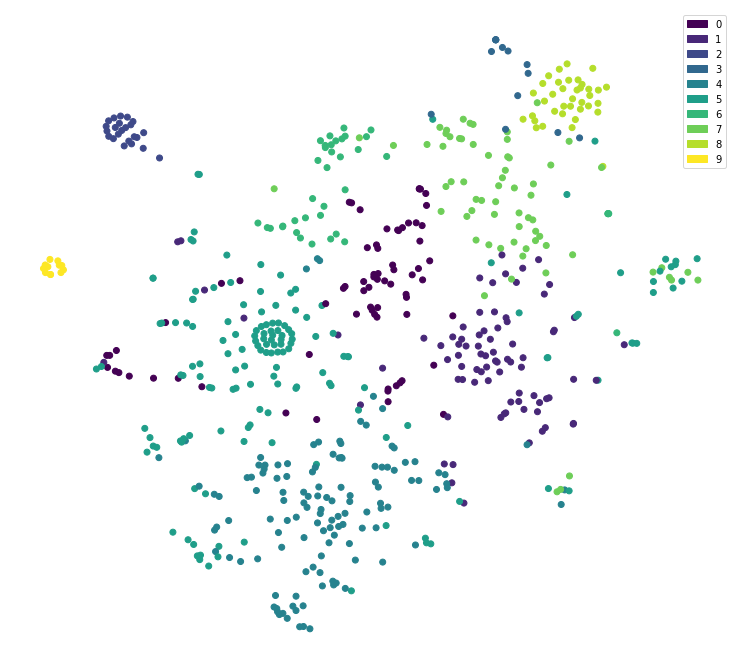

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
#plt.colorbar()
cmap = plt.cm.get_cmap('viridis', num_clusters) 
plt.legend([mpatches.Patch(color=cmap(b)) for b in range(num_clusters)],
           [str(x) for x in range(num_clusters)])
plt.show()

The above is the t-SNE visualization after clustering. may want to improve clarity and try something like [this](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [18]:
cluster_titles = dict()
for cluster, title in zip(clusters, wiki_articles_titles):
    if cluster not in cluster_titles:
        cluster_titles[cluster] = []
    cluster_titles[cluster].append(title)

In [19]:
for cluster, titles in cluster_titles.items():
    print(cluster, ':' , ', '.join(titles), '\n')

0 : Antigua and Barbuda, Apollo program, NYSE MKT, Australian Labor Party, Ainu people, Aga Khan I, Aga Khan III, Alexander Agassiz, American Chinese cuisine, List of Governors of Alabama, Antarctic Treaty System, Alfred Lawson, Americans with Disabilities Act of 1990, Army, AOL, Anarchism, Alabama, Abraham Lincoln, Academy Awards, Algeria, Austin (disambiguation), Andorra, American Football Conference, Anarcho-capitalism, Demographics of Antigua and Barbuda, Politics of Antigua and Barbuda, Antisemitism, Economy of Azerbaijan, Foreign relations of Azerbaijan, Azerbaijani Armed Forces, Politics of Armenia, Economy of Armenia, Armed Forces of Armenia, Foreign relations of Armenia, Geography of American Samoa, Politics of American Samoa, Economy of American Samoa, Abner Doubleday, Audi, Apple Inc., American Civil War, American Film Institute, ABBA, Allegiance, Agrarianism, Anguilla, Alexander Mackenzie (politician), American (word), Extreme poverty, Alaska, America the Beautiful, America

K-means doesn't guarantee cluster sizes, but we won't worry too much about that for now. 

for `doc_cluster.pkl`: Clusters 9 and 11 clearly worked well, since August and April dates are all grouped. 10 looks pretty good, with a bunch of mathematics terminology (plus some stuff about atoms). 8 looks to be about famous people, 7 is a bit of a mess. Let's call it miscellaneous stuff. 6 is another group of historical people. 5 is... plants/flowers/animals! 4 is another of miscellaneous stuff.. 3 looks like geographical things, 2 is mostly people, 1 is religious things, and 0 looks like greek gods and whatnot. 

for `doc_cluster20.pkl`: 20 clusters definitely improved things a bit. The number of clusters used will be something to experiment with. Maybe I can define some kind of metric later on to show how "good" each num_cluster param is. Once again we have groups of greek mythology, people, august, april, math, and more. 


This is really neat. But the challenge now is to actually generate labels for each cluster myself. [this](https://nlp.stanford.edu/IR-book/html/htmledition/cluster-labeling-1.html) looks like a good reference.

In [21]:
import pandas as pd
articles = {'titles': wiki_articles_titles, 'text': wiki_articles_text, 'cluster':clusters}

In [23]:
wiki_df = pd.DataFrame(articles, index=[clusters] , columns = ['titles', 'text', 'cluster'])


In [24]:
wiki_df.head()

,titles,text,cluster
1,Agnosticism,Agnosticism\n\nAgnosticism is the view that th...,1
4,Argon,Argon\n\nArgon is a chemical element with symb...,4
4,Arsenic,Arsenic\n\nArsenic is a chemical element with ...,4
4,Antimony,Antimony\n\nAntimony is a chemical element wit...,4
5,Actinium,Actinium\n\nActinium is a chemical element wit...,5


In [81]:
from gensim.summarization import keywords
from collections import Counter
import spacy
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
cluster_labels = {}
nlp = spacy.load('en')
for clusternum in range(num_clusters):
    cluster_counter = Counter()
    for article in wiki_df[wiki_df['cluster'] == clusternum]['text'].tolist():
        doc = nlp(article)
        cluster_counter.update([str(x) for x in doc.noun_chunks if str(x).lower() not in stopwords])
    print(clusternum, ', '.join([x[0] for x in cluster_counter.most_common(5)]))
    cluster_labels[clusternum] = ', '.join([x[0] for x in cluster_counter.most_common(5)])
    

0 Lincoln, Azerbaijan, Jackson, the United States, the country
1 Crowley, Aristotle, Speer, Einstein, Wallace
2 August, place, July, the peak, the year
3 Alexander, Amasis, Russia, Egypt, Denmark
4 example, water, acupuncture, autism, the use
5 England, Agassi, Australia, choice, the axiom
6 the city, Amsterdam, Athens, Aarhus, Adelaide
7 Alexander, Augustus, Rome, Apollo, Abu Bakr
8 Afonso, Andrew, Alfred, Alfonso, Ealdred
9 April, the month, the Julian calendar, the Northern Hemisphere, the season


0 [('Lincoln', 348), ('Azerbaijan', 319), ('Jackson', 295), ('the United States', 265), ('the country', 247)]
1 [('Crowley', 203), ('Aristotle', 195), ('Speer', 191), ('Einstein', 168), ('Wallace', 160)]
2 [('August', 30), ('place', 5), ('July', 4), ('the peak', 3), ('the year', 3)]
3 [('Alexander', 30), ('Amasis', 25), ('Russia', 14), ('Egypt', 13), ('Denmark', 12)]
4 [('example', 358), ('water', 214), ('acupuncture', 174), ('autism', 137), ('the use', 126)]
5 [('England', 198), ('Agassi', 148), ('Australia', 132), ('choice', 86), ('the axiom', 79)]
6 [('the city', 382), ('Amsterdam', 180), ('Athens', 133), ('Aarhus', 119), ('Adelaide', 106)]
7 [('Alexander', 308), ('Augustus', 178), ('Rome', 175), ('Apollo', 173), ('Abu Bakr', 143)]
8 [('Afonso', 133), ('Andrew', 122), ('Alfred', 112), ('Alfonso', 101), ('Ealdred', 78)]
9 [('April', 28), ('the month', 3), ('the Julian calendar', 2), ('the Northern Hemisphere', 2), ('the season', 2)]

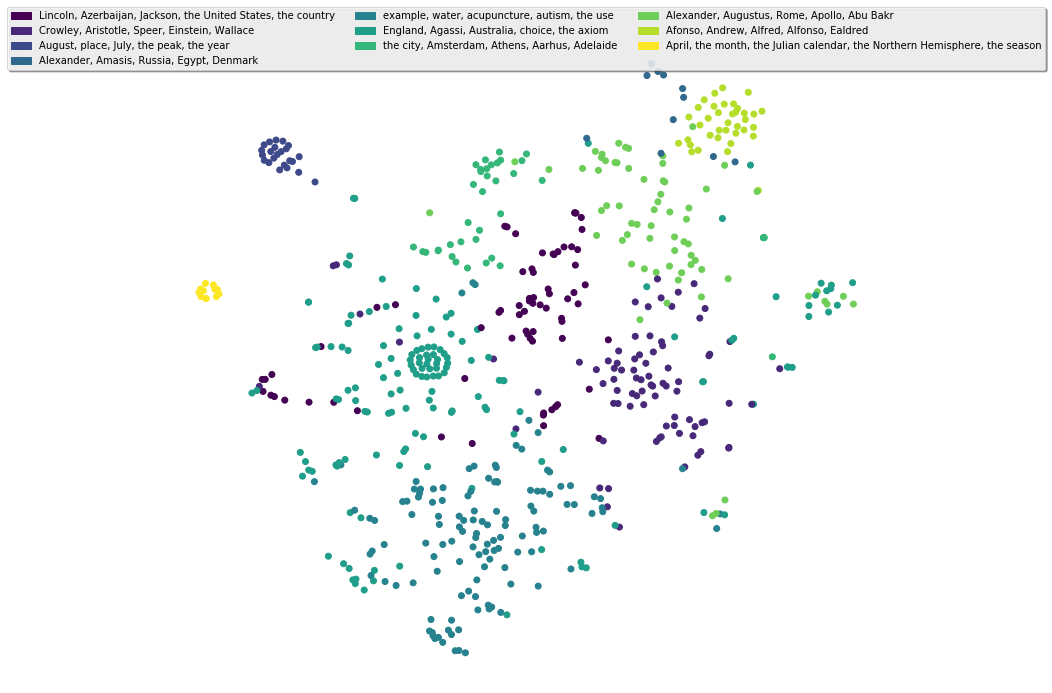

In [92]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
#plt.colorbar()
cmap = plt.cm.get_cmap('viridis', num_clusters) 
plt.legend([mpatches.Patch(color=cmap(b)) for b in range(num_clusters)],
           [cluster_labels[x] for x in range(num_clusters)], loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()